In [44]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import date
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
five_yrs_ago = date.today() - relativedelta(years=5)

In [45]:
df= yf.download('TATAMOTORS.NS', start=five_yrs_ago.strftime("%Y-%m-%d"), end= date.today().strftime("%Y-%m-%d"))
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-08-18,381.750000,383.000000,377.000000,380.399994,380.399994,5856198
2017-08-21,382.000000,382.549988,371.299988,374.350006,374.350006,5123101
2017-08-22,378.799988,379.950012,372.250000,373.600006,373.600006,4163794
2017-08-23,376.000000,381.149994,373.350006,379.950012,379.950012,4448871
2017-08-24,380.100006,385.950012,380.100006,384.149994,384.149994,5208541


In [46]:
df= df.loc[:, 'Low']
df

Date
2017-08-18    377.000000
2017-08-21    371.299988
2017-08-22    372.250000
2017-08-23    373.350006
2017-08-24    380.100006
                 ...    
2022-08-10    463.350006
2022-08-11    475.600006
2022-08-12    470.000000
2022-08-16    478.200012
2022-08-17    484.200012
Name: Low, Length: 1235, dtype: float64

In [47]:
df= df.values.reshape(-1,1)
df_train, df_valid, df_test= df[:int(0.6*len(df)),0], df[int(0.6*len(df)):int(0.8*len(df)),0], df[int(0.8*len(df)):,0]
len(df_test)

247

In [48]:
from sklearn.preprocessing import MinMaxScaler

In [49]:
scaler= MinMaxScaler(feature_range=(-1,1))
scaled_df= scaler.fit_transform(df)

In [50]:
x_train= []
y_train= []
time_step= 100
for i in range(time_step, len(df_train)):
    x_train.append(scaled_df[i-time_step:i,0])
    y_train.append(scaled_df[i,0])

In [51]:
x_train, y_train= np.array(x_train), np.array(y_train)

In [52]:
x_train= np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))


In [53]:
import torch
import torch.nn as nn

In [54]:
device= torch.device('cuda')

In [55]:
x_train= torch.from_numpy(x_train).type(torch.Tensor)
y_train= torch.from_numpy(y_train).type(torch.Tensor)

In [56]:
y_train.shape
y_train= np.reshape(y_train, (y_train.shape[0], 1))

In [57]:
input_dim=1
hidden_dim_lstm= 64
num_layers_lstm= 2         #number of stacks of lstm
output_dim= 1
epochs_lstm= 1000

In [58]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim= hidden_dim
        self.num_layers= num_layers
        self.lstm= nn.LSTM(input_dim, hidden_dim, num_layers, batch_first= True)
        self.fc= nn.Linear(hidden_dim, output_dim)          #fully connected layer after lstm
    def forward(self, x):
        h0= torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()               #.requires_grad is for computing gradients
        c0= torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        out, (hn,cn)= self.lstm(x, (h0.detach(), c0.detach()))
        out= self.fc(out[:,-1,:])           #This represents the final state of the lstm as the output.
        return out

In [59]:
model_lstm= LSTM(input_dim= input_dim, hidden_dim= hidden_dim_lstm, output_dim= output_dim, num_layers= num_layers_lstm)
criterion= torch.nn.MSELoss(reduction= 'mean')
optimizer= torch.optim.Adam(model_lstm.parameters(), lr= 0.01)

In [60]:
model_lstm.cuda()

LSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [61]:
for e in range(epochs_lstm):
    y_train_pred= model_lstm(x_train.cuda())
    loss= criterion(y_train_pred, y_train.cuda())
    optimizer.zero_grad()
    loss.backward()         #Backpropogation
    optimizer.step()        #Gradient descent step

In [62]:
model_lstm.train()

LSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [63]:
valid_input= scaled_df[len(df)-len(df_valid)-time_step:len(df)-len(df_test),0]

In [64]:
valid_input.shape

(100,)

In [65]:
# x_valid=[]
# for i in range(time_step, len(valid_input)):
#     print(valid_input.iloc[i-time_step:i])
#     x_valid.append(valid_input[i-time_step:i])
# x_valid= np.array(x_valid)
# print(x_valid.shape)
# x_valid= torch.from_numpy(np.reshape(x_valid,(x_valid.shape[0], x_valid.shape[1],1))).type(torch.Tensor)

(0,)


IndexError: tuple index out of range

In [66]:
test_input= scaled_df[len(df)-len(df_test)-time_step:,0]

In [67]:
test_input.shape

(347,)

In [68]:
x_test=[]
for i in range(time_step, len(test_input)):
    x_test.append(test_input[i-time_step:i])
x_test= np.array(x_test)
print(x_test.shape)
x_test= torch.from_numpy(np.reshape(x_test,( x_test.shape[0], x_test.shape[1],1))).type(torch.Tensor)

(247, 100)


In [69]:
from sklearn.metrics import r2_score

def plot_graph(df_type, x_type):
    pred= scaler.inverse_transform(model_lstm(x_type.cuda()).cpu().detach().numpy())
    plt.plot(df_type, color= 'green', label='Real')
    plt.plot(pred, color= 'red', label='Predicted')
    #print(r2_score(pred[:-1],df_type[1:]))

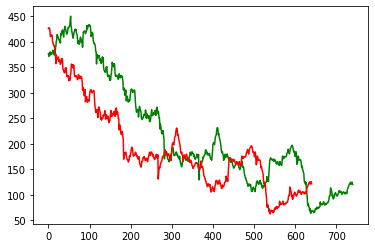

In [70]:
plot_graph(df_train, x_train)

In [71]:
#plot_graph(df_valid, x_valid)

AttributeError: 'numpy.ndarray' object has no attribute 'cuda'

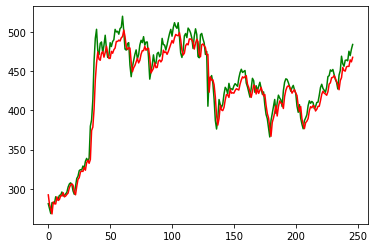

In [72]:
plot_graph(df_test, x_test)

In [ ]:
#print(f'Tomorrow\'s price will be {pred_lstm[-1,0]}')